In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import random



In [40]:
def data_to_tensors(X_train, y_train, X_val, y_val, X_test, y_test):
    X_train_tensor = torch.FloatTensor(X_train.values)
    y_train_tensor = torch.where(torch.FloatTensor(y_train.values) <= 0, 0, 1).float().unsqueeze(1)
    
    X_val_tensor = torch.FloatTensor(X_val.values)
    y_val_tensor = torch.where(torch.FloatTensor(y_val.values) <= 0, 0, 1).float().unsqueeze(1)
    
    X_test_tensor = torch.FloatTensor(X_test.values)
    y_test_tensor = torch.where(torch.FloatTensor(y_test.values) <= 0, 0, 1).float().unsqueeze(1)

    tensors = {
        'X_train': X_train_tensor,
        'y_train': y_train_tensor,
        'X_val': X_val_tensor,
        'y_val': y_val_tensor,
        'X_test': X_test_tensor,
        'y_test': y_test_tensor
    }
    
    return tensors

data = pd.read_csv('data.csv')


X = data.iloc[:, 1:]
y = data.iloc[:, 0]

# First, split the data into train+val set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

# Next, split the train+val set into train set and val set 
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=6)
tensors = data_to_tensors(X_train, y_train, X_val, y_val, X_test, y_test)

In [47]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class Perceptron(nn.Module):
    def __init__(self, input_dim, hidden_layers=None, output_dim=1):
        super(Perceptron, self).__init__()
        if hidden_layers is None:
            hidden_layers = []
        layers = []
        previous_dim = input_dim

        # 创建隐藏层
        for hidden_dim in hidden_layers:
            layers.extend([nn.Linear(previous_dim, hidden_dim), nn.ReLU()])
            previous_dim = hidden_dim

        # 创建输出层
        layers.append(nn.Linear(previous_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def compute_loss_and_accuracy(outputs, targets, criterion):
    loss = criterion(outputs, targets)
    predicted = torch.round(torch.sigmoid(outputs))
    correct = (predicted == targets).sum().item()
    accuracy = correct / len(targets)
    return loss, accuracy


def train_model(model, optimizer, tensors, num_epochs=1000, save_best_model=True, save_dir='saved_models'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    criterion = nn.BCEWithLogitsLoss()
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_val_accuracy = 0

    for epoch in range(num_epochs):
        model.train()
        outputs_train = model(tensors['X_train'])
        loss_train, train_accuracy = compute_loss_and_accuracy(outputs_train, tensors['y_train'], criterion)
        train_losses.append(loss_train.item())
        train_accuracies.append(train_accuracy)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            outputs_val = model(tensors['X_val'])
            loss_val, val_accuracy = compute_loss_and_accuracy(outputs_val, tensors['y_val'], criterion)
            val_losses.append(loss_val.item())
            val_accuracies.append(val_accuracy)

        if save_best_model and val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))

    if save_best_model:
        model.load_state_dict(torch.load(os.path.join(save_dir, 'best_model.pth')))

    model.eval()
    with torch.no_grad():
        outputs_test = model(tensors['X_test'])
        _, test_accuracy = compute_loss_and_accuracy(outputs_test, tensors['y_test'], criterion)

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy
    }


def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(15, 6))

    # 绘制训练和验证的误差
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # 绘制训练和验证的准确率
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()
    
def check_overfitting(results_dict):
    for neurons, results in results_dict.items():
        # 最后一个epoch的训练误差和验证误差
        final_train_loss = results['train_losses'][-1]
        final_val_loss = results['val_losses'][-1]
        loss_difference = final_val_loss - final_train_loss
        
        # 最后一个epoch的训练准确率和验证准确率
        final_train_accuracy = results['train_accuracies'][-1]
        final_val_accuracy = results['val_accuracies'][-1]
        accuracy_difference = final_train_accuracy - final_val_accuracy
        
        print(f"For {neurons} neurons:")
        print(f"Loss difference (Validation - Training): {loss_difference:.4f}")
        print(f"Accuracy difference (Training - Validation): {accuracy_difference:.4f}\n")

def set_seed(seed=6):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)


In [52]:
set_seed(1)
# 定义神经元数量列表
neuron_numbers = [2, 8, 32, 128,256]

# 初始化存储结果的字典
results_dict = {}

for neuron_number in neuron_numbers:
    model = Perceptron(input_dim=X_train.shape[1], hidden_layers=[neuron_number])
    optimizer = torch.optim.Adam(model.parameters())
    results = train_model(model, optimizer, tensors,save_best_model=False)
    
    # 存储结果
    results_dict[neuron_number] = results
    print(f"For {neuron_number} neurons: Test Accuracy = {results['test_accuracy']:.2f}%")


For 2 neurons: Test Accuracy = 0.74%
For 4 neurons: Test Accuracy = 0.74%
For 8 neurons: Test Accuracy = 0.72%
For 16 neurons: Test Accuracy = 0.72%
For 32 neurons: Test Accuracy = 0.71%
For 64 neurons: Test Accuracy = 0.71%
For 128 neurons: Test Accuracy = 0.69%
For 256 neurons: Test Accuracy = 0.67%


In [53]:
check_overfitting(results_dict)


For 2 neurons:
Loss difference (Validation - Training): -0.0207
Accuracy difference (Training - Validation): 0.0072

For 4 neurons:
Loss difference (Validation - Training): -0.0274
Accuracy difference (Training - Validation): -0.0027

For 8 neurons:
Loss difference (Validation - Training): -0.0078
Accuracy difference (Training - Validation): 0.0036

For 16 neurons:
Loss difference (Validation - Training): 0.0264
Accuracy difference (Training - Validation): 0.0458

For 32 neurons:
Loss difference (Validation - Training): 0.0510
Accuracy difference (Training - Validation): 0.0377

For 64 neurons:
Loss difference (Validation - Training): 0.0763
Accuracy difference (Training - Validation): 0.0800

For 128 neurons:
Loss difference (Validation - Training): 0.1615
Accuracy difference (Training - Validation): 0.1087

For 256 neurons:
Loss difference (Validation - Training): 0.2501
Accuracy difference (Training - Validation): 0.1348



In [50]:

set_seed(6)
# 定义神经元数量列表
neuron_configs = [[2], [4, 2], [8, 4, 2], [16, 8, 4, 2], [32, 16, 8, 4, 2], [64, 32, 16, 8, 4, 2]]

# 初始化存储结果的字典
results_dict_optimized = {}

for neuron_config in neuron_configs:
    model = Perceptron(input_dim=X_train.shape[1], hidden_layers=neuron_config)
    optimizer = torch.optim.Adam(model.parameters())
    results = train_model(model, optimizer, tensors,save_best_model=False)
    
    # 存储结果
    results_dict_optimized[tuple(neuron_config)] = results
    print(f"For {neuron_config} neurons: Test Accuracy = {results['test_accuracy']:.2f}%")


For [2] neurons: Test Accuracy = 0.73%
For [4, 2] neurons: Test Accuracy = 0.72%
For [8, 4, 2] neurons: Test Accuracy = 0.70%
For [16, 8, 4, 2] neurons: Test Accuracy = 0.64%
For [32, 16, 8, 4, 2] neurons: Test Accuracy = 0.68%
For [64, 32, 16, 8, 4, 2] neurons: Test Accuracy = 0.70%


In [51]:

check_overfitting(results_dict_optimized)


For (2,) neurons:
Loss difference (Validation - Training): -0.0034
Accuracy difference (Training - Validation): -0.0117

For (4, 2) neurons:
Loss difference (Validation - Training): 0.0000
Accuracy difference (Training - Validation): 0.0225

For (8, 4, 2) neurons:
Loss difference (Validation - Training): 0.0451
Accuracy difference (Training - Validation): 0.0422

For (16, 8, 4, 2) neurons:
Loss difference (Validation - Training): 0.0026
Accuracy difference (Training - Validation): 0.0207

For (32, 16, 8, 4, 2) neurons:
Loss difference (Validation - Training): 0.2228
Accuracy difference (Training - Validation): 0.0898

For (64, 32, 16, 8, 4, 2) neurons:
Loss difference (Validation - Training): 2.6541
Accuracy difference (Training - Validation): 0.1824



In [4]:
def set_seed(seed_value=6):
    """设置所有需要的随机数生成器的种子，确保实验的可复现性。"""
    random.seed(seed_value)  # Python
    np.random.seed(seed_value)  # Numpy
    torch.manual_seed(seed_value)  # Torch
    torch.cuda.manual_seed_all(seed_value)  # 如果使用CUDA

    # 当使用CUDA时，确保所有的实验都是确定性的
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(6)

data = pd.read_csv("data.csv")


X = data.iloc[:, 1:]
y = data.iloc[:, 0]

# First, split the data into train+val set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Next, split the train+val set into train set and val set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.3, random_state=42
)


print(len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test))

371 371 159 159 228 228


In [27]:
set_seed(6)


class Perceptron(nn.Module):
    def __init__(self, input_dim, hidden_layers=[], output_dim=1):
        super(Perceptron, self).__init__()

        layers = []

        previous_dim = input_dim

        # 创建隐藏层
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(previous_dim, hidden_dim))
            layers.append(nn.ReLU())
            previous_dim = hidden_dim

        # 创建输出层
        layers.append(nn.Linear(previous_dim, output_dim))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()

            if outputs.shape[1] == 1:  # Binary
                predicted = torch.round(torch.sigmoid(outputs)).squeeze()
            else:
                _, predicted = outputs.max(1)

            correct += predicted.eq(targets).sum().item()

    accuracy = 100.0 * correct / len(val_loader.dataset)
    return total_loss / len(val_loader), accuracy


def train_model(model, optimizer, tensors, num_epochs=1000, save_dir="saved_models"):
    # 创建保存目录
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    losfun = nn.BCEWithLogitsLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_accuracy = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs_train = model(tensors["X_train"])
        loss_train = losfun(outputs_train, tensors["y_train"])
        train_losses.append(loss_train.item())

        predicted_train = torch.round(torch.sigmoid(outputs_train))
        correct_train = (predicted_train == tensors["y_train"]).sum().item()
        train_accuracy = correct_train / len(tensors["y_train"])
        train_accuracies.append(train_accuracy)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            outputs_val = model(tensors["X_val"])
            loss_val = losfun(outputs_val, tensors["y_val"])
            val_losses.append(loss_val.item())

            predicted_val = torch.round(torch.sigmoid(outputs_val))
            correct_val = (predicted_val == tensors["y_val"]).sum().item()
            val_accuracy = correct_val / len(tensors["y_val"])
            val_accuracies.append(val_accuracy)

        # Save model if it's the best so far
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))

    # Load best model and evaluate on test set
    model.load_state_dict(torch.load(os.path.join(save_dir, "best_model.pth")))
    model.eval()

    with torch.no_grad():
        outputs_test = model(tensors["X_test"])
        predicted_test = torch.round(torch.sigmoid(outputs_test))
        correct_test = (predicted_test == tensors["y_test"]).sum().item()
        test_accuracy = correct_test / len(tensors["y_test"])

    results = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "test_accuracy": test_accuracy,
    }

    return results


def data_to_tensors(X_train, y_train, X_val, y_val, X_test, y_test):
    X_train_tensor = torch.FloatTensor(X_train.values)
    y_train_tensor = (
        torch.where(torch.FloatTensor(y_train.values) <= 0, 0, 1).float().unsqueeze(1)
    )

    X_val_tensor = torch.FloatTensor(X_val.values)
    y_val_tensor = (
        torch.where(torch.FloatTensor(y_val.values) <= 0, 0, 1).float().unsqueeze(1)
    )

    X_test_tensor = torch.FloatTensor(X_test.values)
    y_test_tensor = (
        torch.where(torch.FloatTensor(y_test.values) <= 0, 0, 1).float().unsqueeze(1)
    )

    tensors = {
        "X_train": X_train_tensor,
        "y_train": y_train_tensor,
        "X_val": X_val_tensor,
        "y_val": y_val_tensor,
        "X_test": X_test_tensor,
        "y_test": y_test_tensor,
    }

    return tensors


def plot_from_results(results):
    train_losses = results["train_losses"]
    val_losses = results["val_losses"]
    train_accuracies = results["train_accuracies"]
    val_accuracies = results["val_accuracies"]

    plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)


def train_model_without_best_saving(model, optimizer, tensors, num_epochs=1000):
    losfun = nn.BCEWithLogitsLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs_train = model(tensors["X_train"])
        loss_train = losfun(outputs_train, tensors["y_train"])
        train_losses.append(loss_train.item())

        predicted_train = torch.round(torch.sigmoid(outputs_train))
        correct_train = (predicted_train == tensors["y_train"]).sum().item()
        train_accuracy = correct_train / len(tensors["y_train"])
        train_accuracies.append(train_accuracy)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            outputs_val = model(tensors["X_val"])
            loss_val = losfun(outputs_val, tensors["y_val"])
            val_losses.append(loss_val.item())

            predicted_val = torch.round(torch.sigmoid(outputs_val))
            correct_val = (predicted_val == tensors["y_val"]).sum().item()
            val_accuracy = correct_val / len(tensors["y_val"])
            val_accuracies.append(val_accuracy)

    # Evaluate on test set without loading best model
    model.eval()
    with torch.no_grad():
        outputs_test = model(tensors["X_test"])
        predicted_test = torch.round(torch.sigmoid(outputs_test))
        correct_test = (predicted_test == tensors["y_test"]).sum().item()
        test_accuracy = correct_test / len(tensors["y_test"])

    results = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "test_accuracy": test_accuracy,
    }

    return results


def check_overfitting(results_dict):
    for neurons, results in results_dict.items():
        # 最后一个epoch的训练误差和验证误差
        final_train_loss = results["train_losses"][-1]
        final_val_loss = results["val_losses"][-1]
        loss_difference = final_val_loss - final_train_loss

        # 最后一个epoch的训练准确率和验证准确率
        final_train_accuracy = results["train_accuracies"][-1]
        final_val_accuracy = results["val_accuracies"][-1]
        accuracy_difference = final_train_accuracy - final_val_accuracy

        print(f"For {neurons} neurons:")
        print(f"Loss difference (Validation - Training): {loss_difference:.4f}")
        print(
            f"Accuracy difference (Training - Validation): {accuracy_difference:.4f}\n"
        )


def plot_results(results_dict):
    plt.figure(figsize=(15, 6))

    # 绘制训练和验证的误差
    plt.subplot(1, 2, 1)
    for neurons, results in results_dict.items():
        plt.plot(results["train_losses"], label=f"{neurons} neurons - train")
        plt.plot(
            results["val_losses"], label=f"{neurons} neurons - val", linestyle="--"
        )
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    # 绘制训练和验证的准确率
    plt.subplot(1, 2, 2)
    for neurons, results in results_dict.items():
        plt.plot(results["train_accuracies"], label=f"{neurons} neurons - train")
        plt.plot(
            results["val_accuracies"], label=f"{neurons} neurons - val", linestyle="--"
        )
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.tight_layout()
    plt.show()

In [24]:
set_seed(6)
tensors = data_to_tensors(X_train, y_train, X_val, y_val, X_test, y_test)
model = Perceptron(input_dim=X_train.shape[1], hidden_layers=[])
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.01)

results = train_model(model, optimizer, tensors)
print("Test Accuracy:", results["test_accuracy"])

Test Accuracy: 0.6666666666666666


In [87]:
set_seed(6)
# 定义神经元数量列表
neuron_numbers = [
    [2],
    [4, 2],
    [8, 4, 2],
    [16, 8, 4, 2],
    [32, 16, 8, 4, 2],
    [64, 32, 16, 8, 4, 2],
]

# 初始化存储结果的字典
results_dict = {}

for neuron_list in neuron_numbers:
    combined_results = {
        "train_losses": [],
        "val_losses": [],
        "train_accuracies": [],
        "val_accuracies": [],
        "test_accuracy": 0,
    }
    for neurons in neuron_list:
        model = Perceptron(input_dim=X_train.shape[1], hidden_layers=[neurons])
        optimizer = torch.optim.Adam(model.parameters())
        results = train_model_without_best_weights(model, optimizer, tensors)

        # 结合结果
        combined_results["train_losses"] += results["train_losses"]
        combined_results["val_losses"] += results["val_losses"]
        combined_results["train_accuracies"] += results["train_accuracies"]
        combined_results["val_accuracies"] += results["val_accuracies"]
        combined_results["test_accuracy"] += results["test_accuracy"]

    # 存储结果
    results_dict[tuple(neuron_list)] = combined_results
    print(
        f"For {neuron_list} neurons: Test Accuracy = {combined_results['test_accuracy'] / len(neuron_list):.2f}%"
    )

For [2] neurons: Test Accuracy = 0.76%
For [4, 2] neurons: Test Accuracy = 0.75%
For [8, 4, 2] neurons: Test Accuracy = 0.70%
For [16, 8, 4, 2] neurons: Test Accuracy = 0.74%
For [32, 16, 8, 4, 2] neurons: Test Accuracy = 0.73%
For [64, 32, 16, 8, 4, 2] neurons: Test Accuracy = 0.73%


In [89]:
check_overfitting(results_dict)

For (2,) neurons:
Loss difference (Validation - Training): 0.0070
Accuracy difference (Training - Validation): 0.0189

For (4, 2) neurons:
Loss difference (Validation - Training): 0.0154
Accuracy difference (Training - Validation): 0.0359

For (8, 4, 2) neurons:
Loss difference (Validation - Training): 0.0283
Accuracy difference (Training - Validation): 0.0431

For (16, 8, 4, 2) neurons:
Loss difference (Validation - Training): 0.0242
Accuracy difference (Training - Validation): 0.0368

For (32, 16, 8, 4, 2) neurons:
Loss difference (Validation - Training): 0.0018
Accuracy difference (Training - Validation): 0.0171

For (64, 32, 16, 8, 4, 2) neurons:
Loss difference (Validation - Training): 0.0154
Accuracy difference (Training - Validation): 0.0647



In [85]:
set_seed(6)
# 定义神经元数量列表
neuron_numbers = [2, 4, 8, 16, 32, 64]

# 初始化存储结果的字典
results_dict = {}

for neuron_number in neuron_numbers:
    model = Perceptron(input_dim=X_train.shape[1], hidden_layers=[neuron_number])
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.01)
    results = train_model(model, optimizer, tensors)

    # 存储结果
    results_dict[neuron_number] = results
    print(
        f"For {neuron_number} neurons: Test Accuracy = {results['test_accuracy']:.2f}%"
    )

TypeError: unhashable type: 'list'

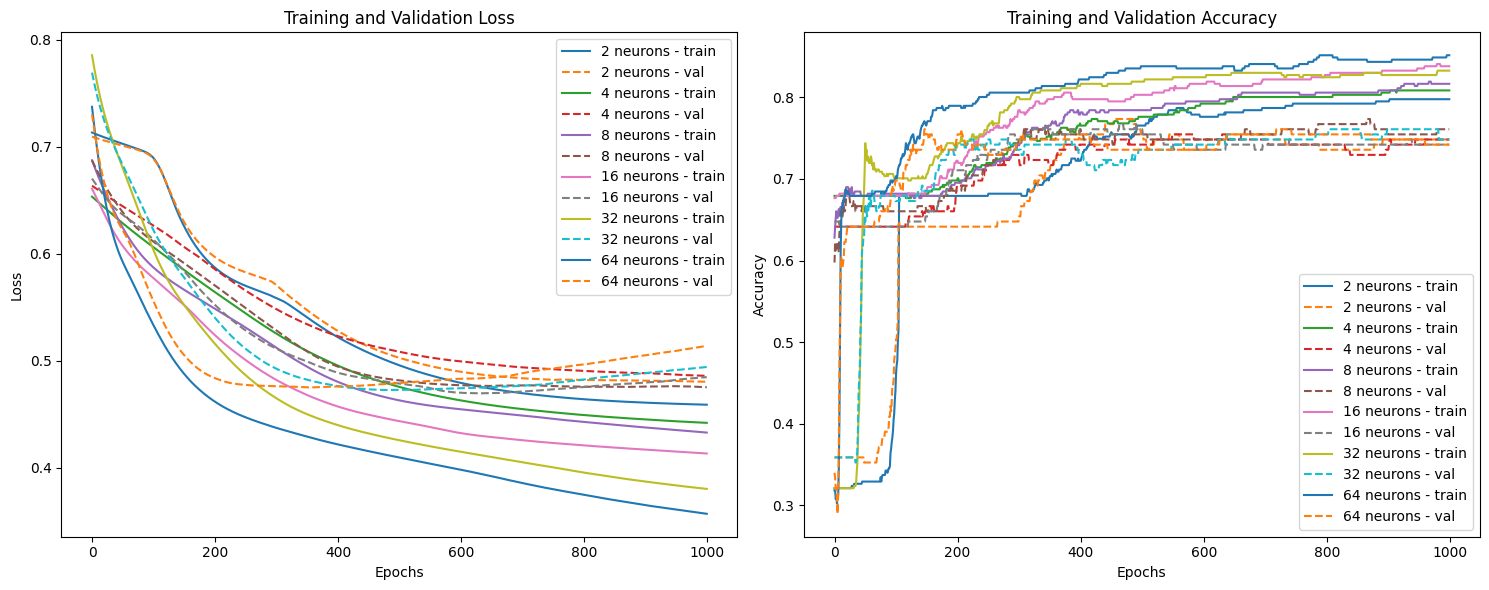

In [8]:
plot_results(results_dict)

In [26]:
# 使用先前的实验结果进行检查
check_overfitting(results_dict)

For 2 neurons:
Loss difference (Validation - Training): 0.0070
Accuracy difference (Training - Validation): 0.0189

For 4 neurons:
Loss difference (Validation - Training): 0.0265
Accuracy difference (Training - Validation): 0.0305

For 8 neurons:
Loss difference (Validation - Training): 0.0676
Accuracy difference (Training - Validation): 0.0961

For 16 neurons:
Loss difference (Validation - Training): 0.0507
Accuracy difference (Training - Validation): 0.0818

For 32 neurons:
Loss difference (Validation - Training): 0.1054
Accuracy difference (Training - Validation): 0.1150

For 64 neurons:
Loss difference (Validation - Training): 0.1812
Accuracy difference (Training - Validation): 0.1330



In [82]:
set_seed(10)
tensors = data_to_tensors(X_train, y_train, X_val, y_val, X_test, y_test)
model = Perceptron(input_dim=X_train.shape[1], hidden_layers=[128])

results = train_model_without_best_weights(model, optimizer, tensors)
print("Test Accuracy:", results["test_accuracy"])

Test Accuracy: 0.75


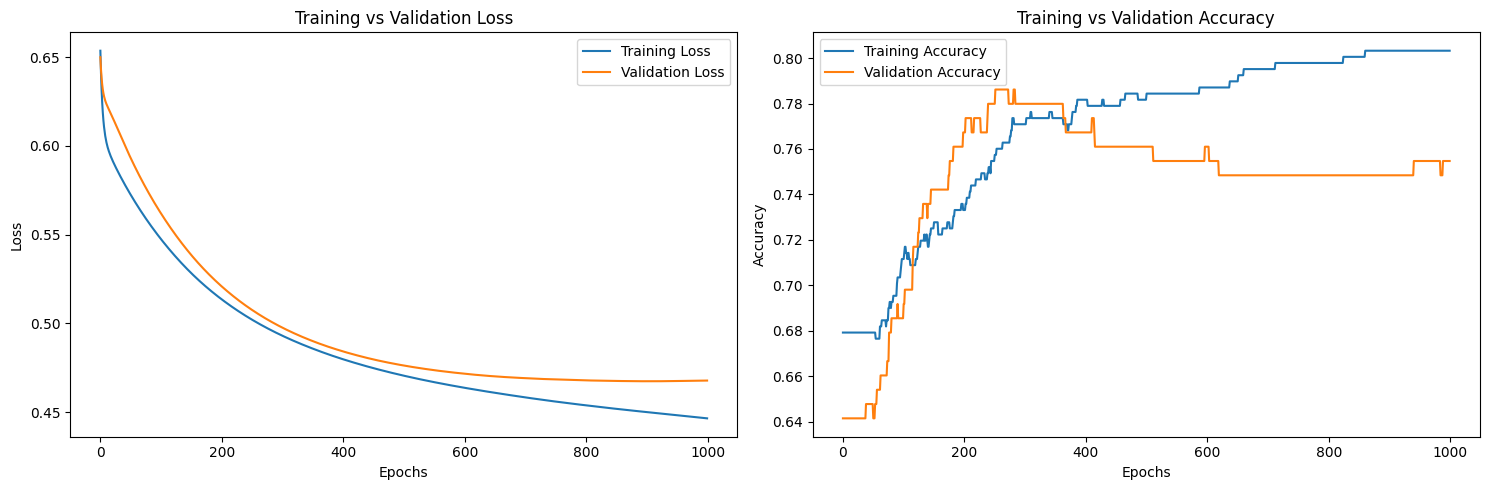

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [83]:
def visualize_overfitting(results):
    epochs = range(len(results["train_losses"]))

    plt.figure(figsize=(15, 5))

    # Plotting the Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, results["train_losses"], label="Training Loss")
    plt.plot(epochs, results["val_losses"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training vs Validation Loss")

    # Plotting the Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, results["train_accuracies"], label="Training Accuracy")
    plt.plot(epochs, results["val_accuracies"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training vs Validation Accuracy")

    plt.tight_layout()
    plt.show()


visualize_overfitting(results)